In [1]:
import pandas as pd
import json
import os
import seaborn as sns
sns.set(style='ticks', context='paper')
import numpy as np
from util import plot_scatter,plot_cdf
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
P99_PERCENTILE_LIST = np.arange(1, 101, 1)
MTU=1000
BDP = 10 * MTU
bin_size_list=[MTU, BDP, 5 * BDP]
labels = {0: '0<size<=MTU', 1:'MTU<size<=BDP', 2:'BDP<size<=5BDP', 3:'5BDP<size'}

n_size_bucket_list_output=len(bin_size_list)+1
n_percentiles=len(P99_PERCENTILE_LIST)
file2matrix = {
        '../../workload/spatials/cluster_a_2_16.json': 'Traffic Matrix A',
        '../../workload/spatials/cluster_b_2_16.json': 'Traffic Matrix B',
        '../../workload/spatials/cluster_c_2_16.json': 'Traffic Matrix C',
    }
file2oversub = {
        'spec/cluster_1_to_1.json': '1-to-1',
        'spec/cluster_2_to_1.json': '2-to-1',
        'spec/cluster_4_to_1.json': '4-to-1',
    }
file2dist = {
    '../../workload/distributions/facebook/webserver-all.txt': 'WebServer',
    '../../workload/distributions/facebook/hadoop-all.txt': 'Hadoop',
    '../../workload/distributions/facebook/cachefollower-all.txt': 'CacheFollower',
}
load_dict={
    0: "load: 0.25-0.35",
    1: "load: 0.35-0.45",
    2: "load: 0.45-0.55",
    3: "load: 0.55-0.65",
    4: "load: 0.65-0.75",
}
window_dict={
    0: "window: 05-14KB",
    1: "window: 14-23KB",
    2: "window: 23-30KB",
}
bfsz_dict={
    0: "buffer: 200-300KB",
    1: "buffer: 300-400KB",
    2: "buffer: 400-500KB",
}
dctcp_k_dict={
    0: "k: 05-9KB",
    1: "k: 09-13KB",
    2: "k: 13-17KB",
    3: "k: 17-20KB",
}
timely_tmin_dict={
    0: "tmin: 40-45us",
    1: "tmin: 45-50us",
    2: "tmin: 50-55us",
    3: "tmin: 55-60us",
}
timely_tmax_dict={
    0: "tmax: 100-113us",
    1: "tmax: 113-126us",
    2: "tmax: 126-139us",
    3: "tmax: 139-150us",
}
hp_ai_dict={
    0: "ai: 0500-625mbps",
    1: "ai: 0625-750mbps",
    2: "ai: 0750-875mbps",
    3: "ai: 875-1000mbps",
}
hp_ita_dict={
    0: "ita: 0.7-0.77",
    1: "ita: 0.77-0.84",
    2: "ita: 0.84-0.91",
    3: "ita: 0.91-0.95",
}
dcqcn_kmin_dict={
    0: "kmin: 20-28KB",
    1: "kmin: 28-36KB",
    2: "kmin: 36-44KB",
    3: "kmin: 44-50KB",
}
dcqcn_kmax_dict={
    0: "kmax: 50-63KB",
    1: "kmax: 63-76KB",
    2: "kmax: 76-89KB",
    3: "kmax: 89-100KB",
}
cc_legend_dict={
    "dctcp": "DCTCP",
    "timely": "TIMELY",
    "dcqcn": "DCQCN",
    "hp": "HPCC",
}
size_legend_list=['(a) flow size $\in$ (0, 1KB)','(b) flow size $\in$ [1KB,10KB)','(c) flow size $\in$ [10KB,50KB)','(d) flow size $\in$ [50KB,$\infty$)']

(2, 5, 26)
(2, 26, 2)
(26, 2)
(26, 2)
(2, 26, 2)
(26, 2)
(26, 2)
(2, 26, 2)
(26, 2)
(26, 2)
(2, 26, 2)
(26, 2)
(26, 2)
error_abs:  (5, 26)
median error:  [0.06465245 0.18570785 0.18697114 0.0091777  0.09020557]
90% error:  [0.07805605 0.28018893 0.20968858 0.03886799 0.12126347]
max error:  [0.09730667 0.3087716  0.21218711 0.05118867 0.14033889]


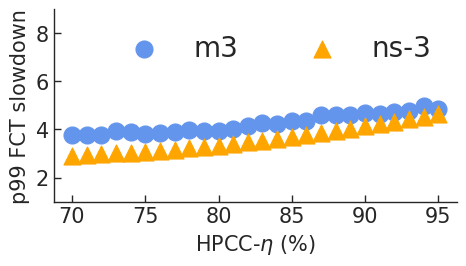

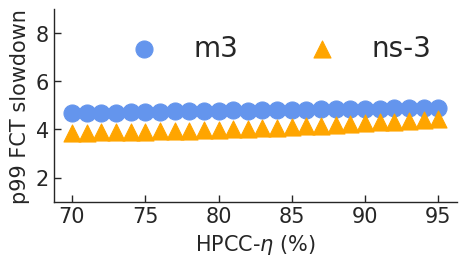

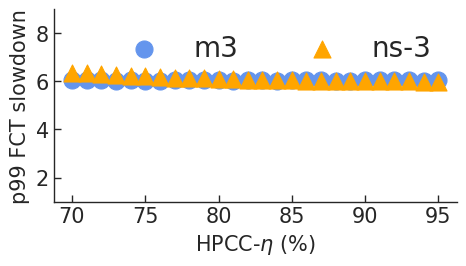

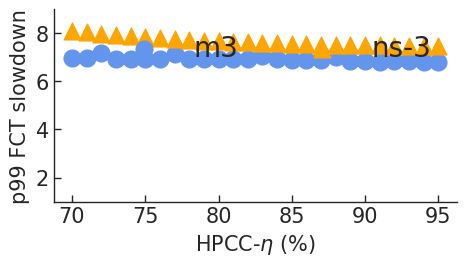

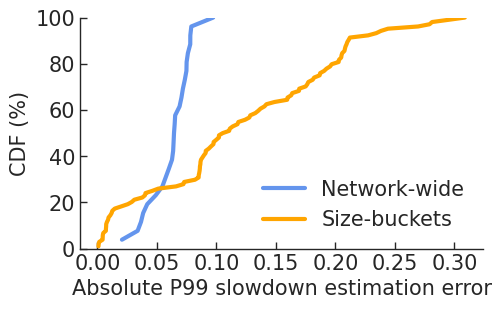

In [3]:
N_FLOW_THRESHOLD=1
NR_PATHS_SAMPLED=500
NR_INTEPOLATE=100
N_FLOWS=NR_PATHS_SAMPLED*NR_INTEPOLATE*4
data_dir='_hpcc'
shard_seed=3

mlsys_dir_list=[f"mlsys"]
legend_list=['ns3-config','pmn-m',"mlsys"]
mix_file = f'../spec/all_counterfactual{data_dir}.mix.json'
with open(mix_file) as f:
    mixes = json.load(f) 
res=[]
for mlsys_dir_idx,mlsys_dir in enumerate(mlsys_dir_list):
    save_file=f'./config_gen_{mlsys_dir}_p{NR_PATHS_SAMPLED}_l{NR_INTEPOLATE}_t{N_FLOW_THRESHOLD}{data_dir}.npz'
    if not os.path.exists(save_file):
        res_final=[]
        for mix in mixes:
            worst_low_id=mix['id']
            mix_dir = f'../data{data_dir}/{worst_low_id}'
            
            if not os.path.exists(f'{mix_dir}/{legend_list[0]}/elapsed_{shard_seed}.txt'):
                print(f'{worst_low_id}: No GT!')
                res_final.append(np.zeros((n_size_bucket_list_output+1,2)))
                continue
            df_pmn_m = pd.read_csv(f'{mix_dir}/{legend_list[1]}/records.csv')
            df_mlsys = [[] for _ in range(n_size_bucket_list_output)]
            
            res_tmp=[]
            
            n_freq_list=[]
            n_flow_list=[]
            sizes_pmn=df_pmn_m['size']
            
            path_idx=0
            while os.path.exists(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt'):
                with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
                    lines = file.readlines()
                    data=lines[0].strip().split(",")
                    n_freq_list.append(int(data[-1]))
                    
                    flowid_list=[int(tmp) for tmp in lines[2].strip().split(",")]
                    size_list=[sizes_pmn[flowid] for flowid in flowid_list]
                    
                    n_links=len(data[0].split("|"))-1
                    tmp=np.digitize(size_list, bin_size_list)
                    # Count occurrences of each bin index
                    bin_counts = np.zeros(n_size_bucket_list_output)
                    for bin_idx in tmp:
                        bin_counts[bin_idx]+=1
                    n_flow_list.append(bin_counts)
                path_idx+=1
            assert sum(n_freq_list)==NR_PATHS_SAMPLED
            n_flow_list=np.array(n_flow_list)
            n_flow_list_sum=n_flow_list.sum(axis=0)
            
            with open(f'{mix_dir}/{mlsys_dir}/path.txt', 'r') as file:
                lines = file.readlines()
                lines = lines[1:]
                for line_idx,line in enumerate(lines):
                    data=line.strip().split(",")
                    data = [float(value) for value in data]
                    assert len(data) == NR_INTEPOLATE
                    n_freq=n_freq_list[line_idx//n_size_bucket_list_output]
                    
                    n_flows_tmp=n_flow_list[line_idx//n_size_bucket_list_output][line_idx%n_size_bucket_list_output]
                    if n_flows_tmp>=N_FLOW_THRESHOLD:
                        for _ in range(n_freq):
                            df_mlsys[line_idx%n_size_bucket_list_output].append(1.0)
                            df_mlsys[line_idx%n_size_bucket_list_output].extend(data)
                    
            df_mlsys_shape=[len(df_mlsys[i]) for i in range(len(df_mlsys))]
            df_ns3 = pd.read_csv(f'{mix_dir}/{legend_list[0]}/records_{shard_seed}.csv')
            
            sizes_ns3=np.array(df_ns3['size'])
            bin_ns3=np.digitize(sizes_ns3, bin_size_list)
            
            bin_counts = np.bincount(bin_ns3)
            total_count = np.sum(bin_counts)
            bucket_ratios = bin_counts / total_count
            
            print(f"{worst_low_id}: {df_mlsys_shape}, {np.max(n_freq_list)}")
            print("bucket_ratios: ",bucket_ratios)
            bucket_ratios_sampled=n_flow_list_sum/sum(n_flow_list_sum)
            print("bucket_ratios_sampled: ",bucket_ratios_sampled)
            
            sldn_mlsys_p99=np.array([np.percentile(df_mlsys[i],99) for i in range(len(df_mlsys))])
            
            print("df_mlsys_p99: ",sldn_mlsys_p99)
            
            df_mlsys_total=[]
            for i in range(len(df_mlsys)):
                n_tmp=int(N_FLOWS*bucket_ratios_sampled[i])
                df_mlsys_total.extend(np.random.choice(df_mlsys[i],n_tmp,replace=True))
            sldn_mlsys_p99=np.percentile(df_mlsys_total,99)

            sldn_ns3=df_ns3['slowdown']
            sldn_ns3_p99=np.percentile(sldn_ns3,99)
            
            print("sldn_ns3: ",sldn_ns3_p99," sldn_mlsys: ", sldn_mlsys_p99)

            res_tmp.append([sldn_ns3_p99,sldn_mlsys_p99])
            
            for i in range(len(bin_size_list)+1):
                tmp_sldn_ns3 = np.extract(bin_ns3==i, sldn_ns3)
                tmp_sldn_mlsys=df_mlsys[i]
                
                sldn_ns3_p99=np.percentile(tmp_sldn_ns3,99)
                df_mlsys_p99=np.percentile(tmp_sldn_mlsys,99)
                res_tmp.append([sldn_ns3_p99,df_mlsys_p99])
            res_final.append(res_tmp)
        res_final = np.array(res_final)
        print("res:", res_final.shape)
        np.savez(save_file,res_final=res_final)
    else:
        data=np.load(save_file)
        res_final=data['res_final']
    if mlsys_dir_idx==0:
        res.append(res_final[:,:,0].transpose())
        res.append(res_final[:,:,1].transpose())
    else:
        res.append(res_final[:,:,-1].transpose())
res=np.array(res)

print(res.shape)
loc_list=[1,1,1,1]
for i in range(1,5):
    res_tmp=res[:,i]
    plot_res=[]
    for mix_id in range(res_tmp.shape[1]):
        mix=mixes[mix_id]
        key_var=mix["param_1"]
        tmp=[[key_var,res_tmp[1,mix_id]],[key_var,res_tmp[0,mix_id]]]
        plot_res.append(tmp)
    plot_res=np.array(plot_res)
    plot_res=plot_res.transpose(1, 0, 2)
    print(plot_res.shape)
    plot_scatter(plot_res,f"figs/counterfactual_size_{i-1}_hpeta.pdf",['m3','ns-3'],'HPCC-$\eta$ (%)',y_label='p99 FCT slowdown',legend_font=20,loc=loc_list[i-1],rotate_xaxis=False,frameon=False,ncol=2,enable_legend=True,text_info=None,text_offset=None,ylim_bottom=1,ylim=9,marker_size=150)

error_abs=abs((res[1]-res[0])/res[0])
plot_data=[error_abs[0],error_abs[1:].flatten()]
print("error_abs: ",error_abs.shape)
plot_cdf(plot_data,None,['Network-wide','Size-buckets'],'Absolute P99 slowdown estimation error',legend_font=15,group_size=len(error_abs),loc=4,rotate_xaxis=False)
print("median error: ", np.median(error_abs,axis=1))
print("90% error: ", np.percentile(error_abs,axis=1, q=90))
print("max error: ", np.max(error_abs,axis=1))


(2, 26, 2)
(2, 26, 2)
(2, 26, 2)
(2, 26, 2)


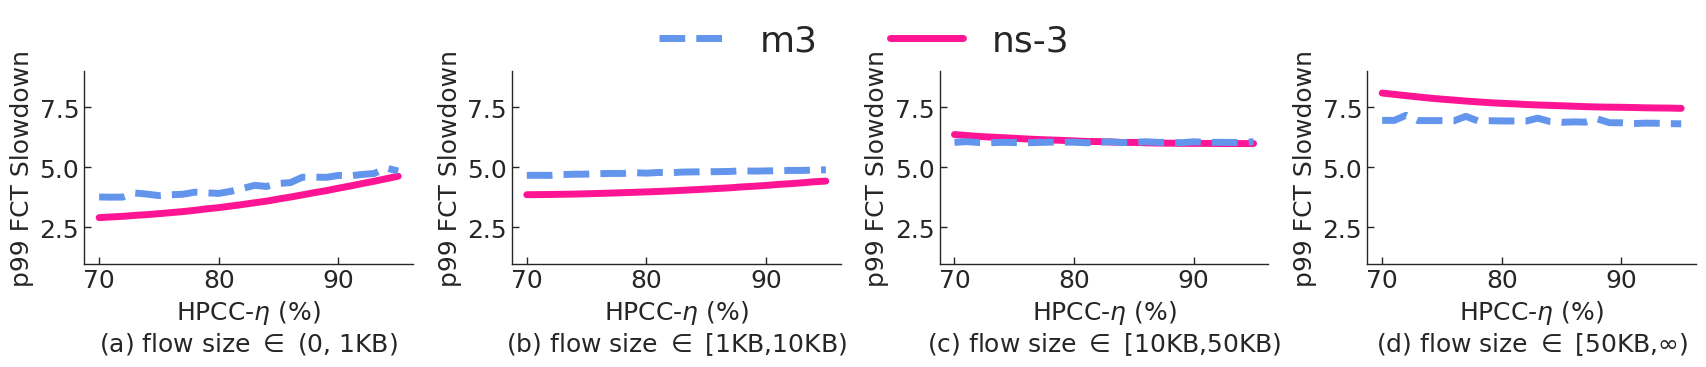

In [10]:

# Define the figure and the subplots
fig, axs = plt.subplots(1, 4, figsize=(5.2*4, 2.5))  # Adjust figsize as needed
loc_list = [1, 1, 1, 1]
_fontsize=18
markertype_list = ["o", "^","x", "x","|"]
color_list = [
    "cornflowerblue",
    "deeppink",
]
line_list = ["--","-", "-.", ":"]
for i in range(1, 5):
    res_tmp=res[:,i]
    plot_res=[]
    for mix_id in range(res_tmp.shape[1]):
        mix=mixes[mix_id]
        key_var=mix["param_1"]
        tmp=[[key_var,res_tmp[1,mix_id]],[key_var,res_tmp[0,mix_id]]]
        plot_res.append(tmp)
    plot_res=np.array(plot_res)
    plot_res=plot_res.transpose(1, 0, 2)
    print(plot_res.shape)

    # Select the subplot to draw on
    ax = axs[i-1]
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    ax.tick_params(axis="y", direction="in")
    ax.tick_params(axis="x", direction="in")
    
    # Plotting on the selected subplot
    for line_idx,line in enumerate(plot_res):
        # ax.scatter(line[:,0], line[:,1], s=100,color=color_list[line_idx],marker=markertype_list[line_idx])  # Adjust marker size as needed
        ax.plot(line[:, 0], line[:, 1], color=color_list[line_idx],linewidth=5,linestyle=line_list[line_idx],zorder=10-line_idx)

    ax.set_xlabel(f'HPCC-$\eta$ (%)\n{size_legend_list[i-1]}',fontsize=_fontsize)
    ax.set_ylabel('p99 FCT Slowdown',fontsize=_fontsize)
    # ax.legend(['m3', 'ns-3'], loc=loc_list[i-1], fontsize=20, frameon=False, ncol=2)

    ax.set_ylim([1, 9])
    ax.tick_params(axis='both', which='major', labelsize=_fontsize)
# Adjust layout

fig.legend(['m3', 'ns-3'], loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=len(labels), fontsize=_fontsize+8, frameon=False, markerscale=1.5)
# plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.savefig(f"figs/counterfactual_hpeta.pdf", bbox_inches="tight", pad_inches=0)

In [10]:
root_dir_baseline="../data_hpcc"
time_elapsed=defaultdict(lambda:[])
method_list=['ns3-config',f'pmn-m',f'mlsys']

time_preprop=defaultdict(lambda:[])
time_path_sim=defaultdict(lambda:[])
for mix_id in range(26):
    for method in method_list:
        if method.startswith('pmn'):
            with open(f'{root_dir_baseline}/{mix_id}/{method}/elapsed.txt') as file:
                for line in file:
                    tmp=line.rstrip()
                    time_elapsed[method].append(int(tmp))
        elif method.startswith('ns3'):
            file_path_1=f'{root_dir_baseline}/{mix_id}/{method}/{shard_seed}/output.txt'
            file_path_2=f'{root_dir_baseline}/{mix_id}/{method}/{shard_seed}/topology.txt'
            # Get the last modified times of the files
            last_modified_time_1 = os.path.getmtime(file_path_1)
            last_modified_time_2 = os.path.getmtime(file_path_2)
            time_difference_seconds = int(abs(last_modified_time_1 - last_modified_time_2))
            time_elapsed[method].append(time_difference_seconds)
        else:
            if os.path.exists(f'{root_dir_baseline}/{mix_id}/{method}/elapsed.txt'):
                with open(f'{root_dir_baseline}/{mix_id}/{method}/elapsed.txt') as file:
                    for line in file:
                        tmp=line.rstrip().split(',')
                        time_elapsed[method].append(int(tmp[0]))
            
print([f"{key}: {np.min(time_elapsed[key])},{np.median(time_elapsed[key])},{np.max(time_elapsed[key])}" for key in time_elapsed])
print([f"{key}: {np.mean(time_elapsed[key])}" for key in time_elapsed])
legend_list=['ns3','pmn-m','m3']
res=np.array(list(time_elapsed.values()))
print(res.shape)

['ns3-config: 17208,17460.0,17724', 'pmn-m: 38,39.5,44', 'mlsys: 21,22.0,26']
['ns3-config: 17474.846153846152', 'pmn-m: 40.34615384615385', 'mlsys: 22.884615384615383']
(3, 26)


(2, 5, 26)
(2, 26, 2)
(26, 2)
(26, 2)
(2, 26, 2)
(26, 2)
(26, 2)
(2, 26, 2)
(26, 2)
(26, 2)
(2, 26, 2)
(26, 2)
(26, 2)
error_abs:  (5, 26)
median error:  [0.05856956 0.11919122 0.12962137 0.00978075 0.08866655]
90% error:  [0.07335234 0.15558067 0.15116665 0.02009244 0.12331288]
max error:  [0.08064914 0.1667371  0.15646761 0.0553771  0.15622408]


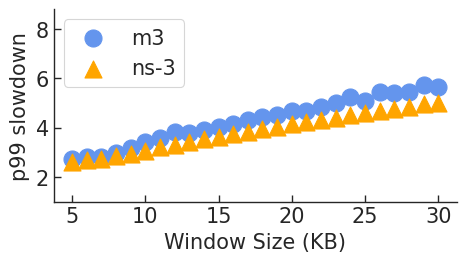

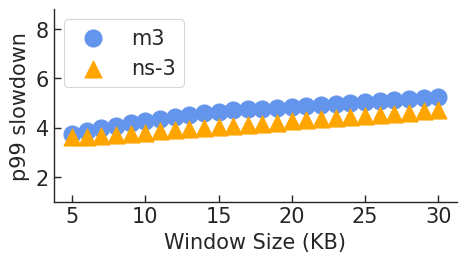

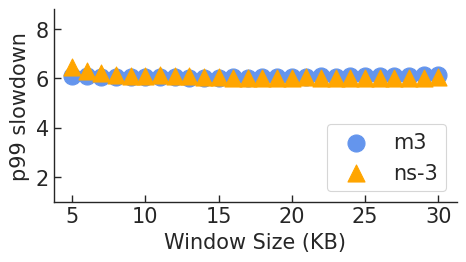

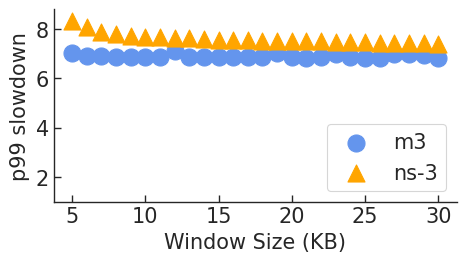

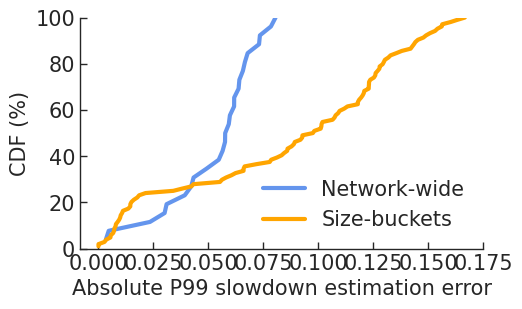

In [11]:
N_FLOW_THRESHOLD=1
NR_PATHS_SAMPLED=500
NR_INTEPOLATE=100
N_FLOWS=NR_PATHS_SAMPLED*NR_INTEPOLATE*4
data_dir='_window'
shard_seed=3

mix_file = f'../spec/all_counterfactual{data_dir}.mix.json'
with open(mix_file) as f:
    mixes = json.load(f) 
    
mlsys_dir_list=[f"mlsys"]
legend_list=['ns3-config','pmn-m',"mlsys"]
res=[]
for mlsys_dir_idx,mlsys_dir in enumerate(mlsys_dir_list):
    save_file=f'./config_gen_{mlsys_dir}_p{NR_PATHS_SAMPLED}_l{NR_INTEPOLATE}_t{N_FLOW_THRESHOLD}{data_dir}.npz'
    if not os.path.exists(save_file):
        res_final=[]
        for mix in mixes:
            worst_low_id=mix['id']
            mix_dir = f'../data{data_dir}/{worst_low_id}'
            if not os.path.exists(f'{mix_dir}/{legend_list[0]}/elapsed_{shard_seed}.txt'):
                print(f'{worst_low_id}: No GT!')
                res_final.append(np.zeros((n_size_bucket_list_output+1,2)))
                continue
            
            df_pmn_m = pd.read_csv(f'{mix_dir}/{legend_list[1]}/records.csv')
            df_mlsys = [[] for _ in range(n_size_bucket_list_output)]
            
            res_tmp=[]
            
            n_freq_list=[]
            n_flow_list=[]
            sizes_pmn=df_pmn_m['size']
            
            path_idx=0
            while os.path.exists(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt'):
                with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
                    lines = file.readlines()
                    data=lines[0].strip().split(",")
                    n_freq_list.append(int(data[-1]))
                    
                    flowid_list=[int(tmp) for tmp in lines[2].strip().split(",")]
                    size_list=[sizes_pmn[flowid] for flowid in flowid_list]
                    
                    n_links=len(data[0].split("|"))-1
                    tmp=np.digitize(size_list, bin_size_list)
                    # Count occurrences of each bin index
                    bin_counts = np.zeros(n_size_bucket_list_output)
                    for bin_idx in tmp:
                        bin_counts[bin_idx]+=1
                    n_flow_list.append(bin_counts)
                path_idx+=1
            assert sum(n_freq_list)==NR_PATHS_SAMPLED
            n_flow_list=np.array(n_flow_list)
            n_flow_list_sum=n_flow_list.sum(axis=0)
            
            with open(f'{mix_dir}/{mlsys_dir}/path.txt', 'r') as file:
                lines = file.readlines()
                lines = lines[1:]
                for line_idx,line in enumerate(lines):
                    data=line.strip().split(",")
                    data = [float(value) for value in data]
                    assert len(data) == NR_INTEPOLATE
                    n_freq=n_freq_list[line_idx//n_size_bucket_list_output]
                    
                    if n_flow_list[line_idx//n_size_bucket_list_output][line_idx%n_size_bucket_list_output]>=N_FLOW_THRESHOLD:
                        for _ in range(n_freq):
                            df_mlsys[line_idx%n_size_bucket_list_output].append(1.0)
                            df_mlsys[line_idx%n_size_bucket_list_output].extend(data)
                    
            df_mlsys_shape=[len(df_mlsys[i]) for i in range(len(df_mlsys))]
            df_ns3 = pd.read_csv(f'{mix_dir}/{legend_list[0]}/records_{shard_seed}.csv')
            
            sizes_ns3=np.array(df_ns3['size'])
            bin_ns3=np.digitize(sizes_ns3, bin_size_list)
            
            bin_counts = np.bincount(bin_ns3)
            total_count = np.sum(bin_counts)
            bucket_ratios = bin_counts / total_count
            
            print(f"{worst_low_id}: {df_mlsys_shape}, {np.max(n_freq_list)}")
            print("bucket_ratios: ",bucket_ratios)
            bucket_ratios_sampled=n_flow_list_sum/sum(n_flow_list_sum)
            print("bucket_ratios_sampled: ",bucket_ratios_sampled)
            
            sldn_mlsys_p99=np.array([np.percentile(df_mlsys[i],99) for i in range(len(df_mlsys))])
            
            print("df_mlsys_p99: ",sldn_mlsys_p99)
            
            df_mlsys_total=[]
            for i in range(len(df_mlsys)):
                n_tmp=int(N_FLOWS*bucket_ratios_sampled[i])
                df_mlsys_total.extend(np.random.choice(df_mlsys[i],n_tmp,replace=True))
            sldn_mlsys_p99=np.percentile(df_mlsys_total,99)

            sldn_ns3=df_ns3['slowdown']
            sldn_ns3_p99=np.percentile(sldn_ns3,99)
            
            print("sldn_ns3: ",sldn_ns3_p99," sldn_mlsys: ", sldn_mlsys_p99)

            res_tmp.append([sldn_ns3_p99,sldn_mlsys_p99])
            
            for i in range(len(bin_size_list)+1):
                tmp_sldn_ns3 = np.extract(bin_ns3==i, sldn_ns3)
                tmp_sldn_mlsys=df_mlsys[i]
                
                sldn_ns3_p99=np.percentile(tmp_sldn_ns3,99)
                df_mlsys_p99=np.percentile(tmp_sldn_mlsys,99)
                res_tmp.append([sldn_ns3_p99,df_mlsys_p99])
            res_final.append(res_tmp)
        res_final = np.array(res_final)
        print("res:", res_final.shape)
        np.savez(save_file,res_final=res_final)
    else:
        data=np.load(save_file)
        res_final=data['res_final']
    if mlsys_dir_idx==0:
        res.append(res_final[:,:,0].transpose())
        res.append(res_final[:,:,1].transpose())
    else:
        res.append(res_final[:,:,-1].transpose())
res=np.array(res)

print(res.shape)

loc_list=[2,2,4,4]
for i in range(1,5):
    res_tmp=res[:,i]
    plot_res=[]
    for mix_id in range(len(mixes)):
        mix=mixes[mix_id]
        key_var=mix["window"]/1000
        tmp=[[key_var,res_tmp[1,mix_id]],[key_var,res_tmp[0,mix_id]]]
        plot_res.append(tmp)
    plot_res=np.array(plot_res)
    plot_res=plot_res.transpose(1, 0, 2)
    print(plot_res.shape)
    plot_scatter(plot_res,f"figs/counterfactual_size_{i-1}_window.pdf",['m3','ns-3'],'Window Size (KB)',y_label='p99 slowdown',legend_font=15,loc=loc_list[i-1],rotate_xaxis=False,frameon=True,ncol=1,enable_legend=True,text_info=None,text_offset=None,ylim_bottom=1,ylim=8.8,marker_size=150)
error_abs=abs(res[1]-res[0])/res[0]
plot_data=[error_abs[0],error_abs[1:].flatten()]
print("error_abs: ",error_abs.shape)
plot_cdf(plot_data,None,['Network-wide','Size-buckets'],'Absolute P99 slowdown estimation error',legend_font=15,group_size=len(error_abs),loc=4,rotate_xaxis=False)
print("median error: ", np.median(error_abs,axis=1))
print("90% error: ", np.percentile(error_abs,axis=1, q=90))
print("max error: ", np.max(error_abs,axis=1))


(2, 26, 2)
(2, 26, 2)
(2, 26, 2)
(2, 26, 2)


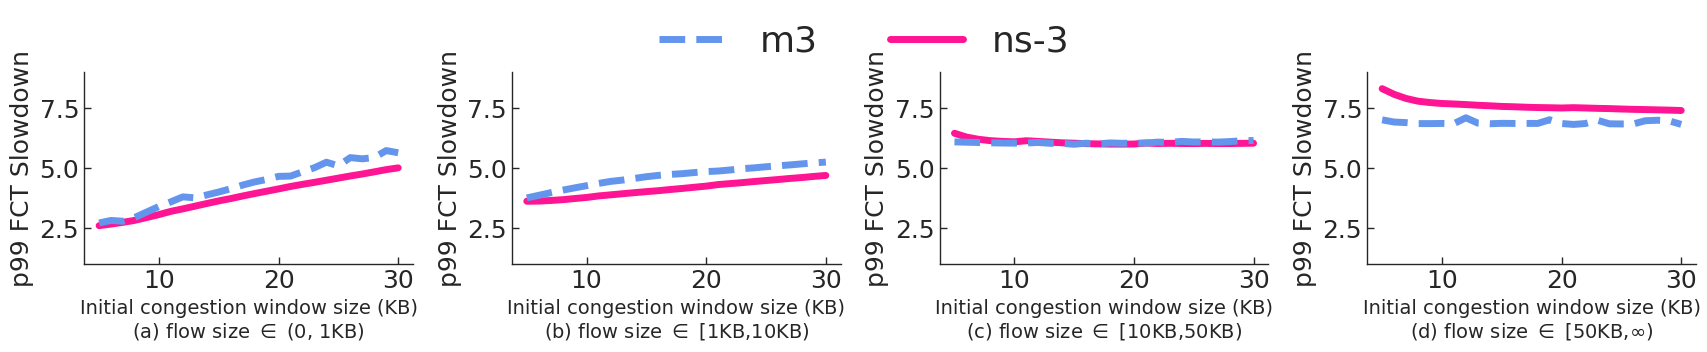

In [12]:

# Define the figure and the subplots
fig, axs = plt.subplots(1, 4, figsize=(5.2*4, 2.5))  # Adjust figsize as needed
loc_list = [1, 1, 1, 1]
_fontsize=18
markertype_list = ["o", "^","x", "x","|"]
color_list = [
    "cornflowerblue",
    "deeppink",
]
for i in range(1, 5):
    res_tmp=res[:,i]
    plot_res=[]
    for mix_id in range(res_tmp.shape[1]):
        mix=mixes[mix_id]
        key_var=mix["window"]/1000
        tmp=[[key_var,res_tmp[1,mix_id]],[key_var,res_tmp[0,mix_id]]]
        plot_res.append(tmp)
    plot_res=np.array(plot_res)
    plot_res=plot_res.transpose(1, 0, 2)
    print(plot_res.shape)

    # Select the subplot to draw on
    ax = axs[i-1]
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    ax.tick_params(axis="y", direction="in")
    ax.tick_params(axis="x", direction="in")
    
    # Plotting on the selected subplot
    for line_idx,line in enumerate(plot_res):
        # ax.scatter(line[:,0], line[:,1], s=100,color=color_list[line_idx],marker=markertype_list[line_idx])  # Adjust marker size as needed
        ax.plot(line[:, 0], line[:, 1], color=color_list[line_idx],linewidth=5,linestyle=line_list[line_idx],zorder=10-line_idx)  # Adjust marker size as needed
    ax.set_xlabel(f'Initial congestion window size (KB)\n{size_legend_list[i-1]}',fontsize=_fontsize-4)
    ax.set_ylabel('p99 FCT Slowdown',fontsize=_fontsize)
    # ax.legend(['m3', 'ns-3'], loc=loc_list[i-1], fontsize=20, frameon=False, ncol=2)

    ax.set_ylim([1, 9])
    ax.tick_params(axis='both', which='major', labelsize=_fontsize)
# Adjust layout

fig.legend(['m3', 'ns-3'], loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=len(labels), fontsize=_fontsize+8, frameon=False, markerscale=1.5)
# plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.savefig(f"figs/counterfactual_window.pdf", bbox_inches="tight", pad_inches=0)

In [84]:
root_dir_baseline="../data_window"
time_elapsed=defaultdict(lambda:[])
method_list=['ns3-config',f'pmn-m',f'mlsys']

time_preprop=defaultdict(lambda:[])
time_path_sim=defaultdict(lambda:[])
for mix_id in range(26):
    for method in method_list:
        if method.startswith('pmn'):
            with open(f'{root_dir_baseline}/{mix_id}/{method}/elapsed.txt') as file:
                for line in file:
                    tmp=line.rstrip()
                    time_elapsed[method].append(int(tmp))
        elif method.startswith('ns3'):
            file_path_1=f'{root_dir_baseline}/{mix_id}/{method}/{shard_seed}/output.txt'
            file_path_2=f'{root_dir_baseline}/{mix_id}/{method}/{shard_seed}/topology.txt'
            # Get the last modified times of the files
            last_modified_time_1 = os.path.getmtime(file_path_1)
            last_modified_time_2 = os.path.getmtime(file_path_2)
            time_difference_seconds = int(abs(last_modified_time_1 - last_modified_time_2))
            time_elapsed[method].append(time_difference_seconds)
        else:
            if os.path.exists(f'{root_dir_baseline}/{mix_id}/{method}/elapsed.txt'):
                with open(f'{root_dir_baseline}/{mix_id}/{method}/elapsed.txt') as file:
                    for line in file:
                        tmp=line.rstrip().split(',')
                        time_elapsed[method].append(int(tmp[0]))
            
print([f"{key}: {np.min(time_elapsed[key])},{np.median(time_elapsed[key])},{np.max(time_elapsed[key])}" for key in time_elapsed])
print([f"{key}: {np.mean(time_elapsed[key])}" for key in time_elapsed])
legend_list=['ns3','pmn-m','m3']
res=np.array(list(time_elapsed.values()))
print(res.shape)

['ns3-config: 27080,28886.0,29229', 'pmn-m: 31,44.0,58', 'mlsys: 20,25.5,31']
['ns3-config: 28740.615384615383', 'pmn-m: 43.34615384615385', 'mlsys: 25.23076923076923']
(3, 26)
